In [ ]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
import loss_funcs
from evaluate import eval_funcs
from algs import *

from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
from utils.visualize import SearchPlotter
from utils.image import ImageUtils

import mealpy
import cv2 as cv

plotter = SearchPlotter(update_freq=100)

# Create a camera configuration
cam_config = CameraConfig(location=(0, 0, 0.1), rotation=(np.pi / 2, 0, 0), fov=60)
world_viewer = ViewSampler("data/mug/world.xml", cam_config, simulation_time=5)
sim_viewer = ViewSampler("data/mug/world_sim.xml", cam_config)

loss_func = loss_funcs.IOU()

alg = UniformSampling(sim_viewer, loss_func=loss_func)
alg_config = UniformSampling.Config(time_limit=200, min_samples=350)

eval_func=eval_funcs.XorDiff(0.1)
evaluator = Evaluator(world_viewer, eval_func=eval_func)

init_location = (0, 1.3, 0.3)
random_orientations = OrientUtils.generate_random(80)
eval_positions = [ObjectPosition(orient, init_location) for orient in random_orientations]

for pos in eval_positions:
    orig_img, new_pos = world_viewer.get_view_cropped(pos)
    orient, loss = alg.solve(orig_img, new_pos.location, alg_config)
    pred_img, _ = world_viewer.get_view_cropped(ObjectPosition(orient, new_pos.location))

    cv.imshow("Original", orig_img)
    cv.waitKey(0)
    cv.imshow("Predicted", pred_img)
    cv.waitKey(0)

    orig_depth, _ = world_viewer.get_view_cropped(new_pos, depth=True, allow_simulation=False)
    pred_depth, _ = world_viewer.get_view_cropped(ObjectPosition(orient, new_pos.location), depth=True, allow_simulation=False)

    eval_loss = eval_func(orig_depth, pred_depth)
    print(eval_loss)

for alg, config in [(alg, alg_config)]:
    eval_losses = evaluator.evaluate(alg, config, eval_positions)
    print(f"{type(alg).__name__}: {eval_losses}")


In [ ]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
import loss_funcs
from evaluate import eval_funcs
from algs import *

from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
# from utils.visualize import SearchPlotter
from utils.image import ImageUtils

import mealpy
import cv2 as cv

# plotter = SearchPlotter(update_freq=100, alpha=[0.985])

# Create a camera configuration
cam_config = CameraConfig(location=(0, 0, 0.3), rotation=(np.pi / 2, 0, 0), fov=60)
world_viewer = ViewSampler("data/hammer/world.xml", cam_config, simulation_time=5)
sim_viewer = ViewSampler("data/hammer/world_sim.xml", cam_config)

loss_func = loss_funcs.IOU()
alg_config = MealAlgorithm.Config(time_limit=15, silent=True)

eval_func=eval_funcs.XorDiff(0.1)

evaluator = Evaluator(world_viewer, eval_func=eval_func)
# evaluator.register_callback(lambda x: plotter.reset())

init_location = (0, 1.3, 0.3)
random_orientations = OrientUtils.generate_uniform(3)
eval_positions = [ObjectPosition(orient, init_location) for orient in random_orientations]

algorithms: list[MealAlgorithm] = [
    MealAlgorithm(sim_viewer, loss_func, mealpy.physics_based.SA.OriginalSA(temp_init=10 * 2 * np.pi, step_size=0.1)),
    MealAlgorithm(sim_viewer, loss_func, mealpy.physics_based.SA.SwarmSA(temp_init=10 * 2 * np.pi, step_size=np.pi/100)),
    MealAlgorithm(sim_viewer, loss_func, mealpy.swarm_based.PSO.OriginalPSO()),
    MealAlgorithm(sim_viewer, loss_func, mealpy.swarm_based.PSO.AIW_PSO()),
]
# meal_alg = mealpy.human_based.BRO.DevBRO()
# meal_alg = mealpy.math_based.CEM.OriginalCEM()
# meal_alg = mealpy.music_based.HS.DevHS(pop_size=10)
# meal_alg = mealpy.swarm_based.PSO.OriginalPSO()
# meal_alg = mealpy.physics_based.SA.OriginalSA(pop_size=10, temp_init=10 * 2 * np.pi, step_size=0.2)
# meal_alg = mealpy.human_based.ICA.OriginalICA(empire_count=7, revolution_rate=0.4) # best!!
# meal_alg = mealpy.bio_based.BBO.DevBBO() # potentially good!
meal_alg = mealpy.bio_based.TSA.OriginalTSA() # potentially good!

algorithms: list[MealAlgorithm] = [
    MealAlgorithm(sim_viewer, loss_func, meal_alg),
]

# evaluator.enable_logging("Ealuations/UniformDet/Mug/IOU/")
for alg in algorithms:
    # alg.register_callback(plotter.add_data)
    eval_losses = evaluator.evaluate(alg, alg_config, eval_positions)
    print(f"{alg.get_name()}: {eval_losses}")

world_viewer.close()
sim_viewer.close()
# plotter.close()

In [ ]:
import loss_funcs
from algs import *

import mealpy
from multiprocessing import Process
import evaluation_process as ev

loss_func = loss_funcs.IOU()
alg_config = MealAlgorithm.Config(time_limit=15, silent=True)
root_path = "Ealuations/OverNight/UniformDet/Hammer/IOU/"

if __name__ == '__main__':
    for idx, (alg_name, meal_alg) in enumerate(mealpy.get_all_optimizers().items()):
        if "DevSARO" not in alg_name:
            continue
        print(f"===================== Epoch {idx} =====================")
        print(f"Starting Evaluation of: {alg_name}")
        p = Process(target=ev.evaluate, args=(meal_alg,alg_config,loss_func,root_path))
        p.start()
        p.join()


In [ ]:
import numpy as np
from utils.orient import OrientUtils
len(OrientUtils.generate_uniform(9))

# Analisys

In [ ]:
import numpy as np

def numerical_derivative(x, y, point, method='central', order=2):
    """
    Approximate the derivative of a graph represented by the points (x, y)
    at the given point using numerical differentiation.

    Parameters:
    x (numpy.ndarray): The x-coordinates of the points.
    y (numpy.ndarray): The y-coordinates of the points.
    point (float): The point at which to approximate the derivative.
    method (str, optional): The differentiation method to use.
        'central' (default): Central difference method.
        'forward': Forward difference method.
        'backward': Backward difference method.
    order (int, optional): The order of the numerical differentiation method.
        2 (default): Second-order accurate method.
        4: Fourth-order accurate method.

    Returns:
    float: The approximated derivative at the given point.
    """
    # Find the index of the point closest to the given point
    idx = np.abs(x - point).argmin()

    if method == 'central':
        if order == 2:
            # Second-order central difference
            dx = x[idx + 1] - x[idx - 1]
            dy = y[idx + 1] - y[idx - 1]
            derivative = dy / dx
        elif order == 4:
            # Fourth-order central difference
            dx1 = x[idx + 1] - x[idx]
            dx2 = x[idx] - x[idx - 1]
            dx3 = x[idx + 2] - x[idx - 2]
            dy1 = y[idx + 1] - y[idx]
            dy2 = y[idx] - y[idx - 1]
            dy3 = y[idx + 2] - y[idx - 2]
            derivative = (-dy3 + 8 * dy2 - 8 * dy1 + dy3) / (6 * (dx1 + dx2))

    elif method == 'forward':
        if order == 2:
            # Second-order forward difference
            dx = x[idx + 1] - x[idx]
            dy = y[idx + 1] - y[idx]
            derivative = dy / dx
        elif order == 4:
            # Fourth-order forward difference
            dx1 = x[idx + 1] - x[idx]
            dx2 = x[idx + 2] - x[idx + 1]
            dx3 = x[idx + 3] - x[idx + 2]
            dy1 = y[idx + 1] - y[idx]
            dy2 = y[idx + 2] - y[idx + 1]
            dy3 = y[idx + 3] - y[idx + 2]
            derivative = (-dy3 + 8 * dy2 - 13 * dy1) / (6 * (dx1 + dx2 + dx3))

    elif method == 'backward':
        if order == 2:
            # Second-order backward difference
            dx = x[idx] - x[idx - 1]
            dy = y[idx] - y[idx - 1]
            derivative = dy / dx
        elif order == 4:
            # Fourth-order backward difference
            dx1 = x[idx] - x[idx - 1]
            dx2 = x[idx - 1] - x[idx - 2]
            dx3 = x[idx - 2] - x[idx - 3]
            dy1 = y[idx] - y[idx - 1]
            dy2 = y[idx - 1] - y[idx - 2]
            dy3 = y[idx - 2] - y[idx - 3]
            derivative = (dy3 - 8 * dy2 + 13 * dy1) / (6 * (dx1 + dx2 + dx3))

    return derivative

In [ ]:
import numpy as np

def numerical_derivative_plot(x, y, method='central', order=2):
    """
    Calculate the numerical derivative for all points in the dataset (x, y)
    using the specified method and order.

    Parameters:
    x (numpy.ndarray): The x-coordinates of the points.
    y (numpy.ndarray): The y-coordinates of the points.
    method (str, optional): The differentiation method to use.
        'central' (default): Central difference method.
        'forward': Forward difference method.
        'backward': Backward difference method.
    order (int, optional): The order of the numerical differentiation method.
        2 (default): Second-order accurate method.
        4: Fourth-order accurate method.

    Returns:
    numpy.ndarray: The numerical derivative values for all points.
    """
    n = len(x)
    derivatives = np.zeros_like(x)

    if method == 'central':
        if order == 2:
            for i in range(1, n - 1):
                derivatives[i] = numerical_derivative(x, y, x[i], method='central', order=order)

            # Handle edge cases for second-order central difference
            derivatives[0] = numerical_derivative(x, y, x[0], method='forward', order=order)
            derivatives[n - 1] = numerical_derivative(x, y, x[n - 1], method='backward', order=order)

        elif order == 4:
            for i in range(2, n - 2):
                derivatives[i] = numerical_derivative(x, y, x[i], method='central', order=order)

            # Handle edge cases for fourth-order central difference
            derivatives[0] = numerical_derivative(x, y, x[0], method='forward', order=order)
            derivatives[1] = numerical_derivative(x, y, x[1], method='forward', order=order)
            derivatives[n - 2] = numerical_derivative(x, y, x[n - 2], method='backward', order=order)
            derivatives[n - 1] = numerical_derivative(x, y, x[n - 1], method='backward', order=order)

    elif method == 'forward':
        if order == 2:
            for i in range(n - 1):
                derivatives[i] = numerical_derivative(x, y, x[i], method='forward', order=order)

        elif order == 4:
            for i in range(n - 3):
                derivatives[i] = numerical_derivative(x, y, x[i], method='forward', order=order)

    elif method == 'backward':
        if order == 2:
            for i in range(1, n):
                derivatives[i] = numerical_derivative(x, y, x[i], method='backward', order=order)

        elif order == 4:
            for i in range(3, n):
                derivatives[i] = numerical_derivative(x, y, x[i], method='backward', order=order)

    return derivatives

In [ ]:
import matplotlib.pyplot as plt

# Example data points
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 8, 16, 32])

# Calculate numerical derivative
derivatives = numerical_derivative_plot(x, y, method='central', order=2)

# Plot the original data and the numerical derivative
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo-', label='Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, derivatives, 'ro-', label='Numerical Derivative')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

plt.tight_layout()
plt.show()

## Plotting Results

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from evaluate.eval_log import EvalLog
from mealpy.utils.history import History
from utils.file import LogFiles
import numpy as np
from algs.algorithm import RunHistory



In [ ]:
import shutil
# shutil.make_archive("FinalEvaluation2_new",'zip','Final_Evaluation2/Eval/')

### Validate experiment results

In [ ]:
import os
# merge results
path = "Final_Evaluation2/Eval2/"
new_root = "Final_Evaluation2/Eval/"

directories = LogFiles(path, scan_dirs=True)

for directory in directories:
    obj_name = directories.get_filename()
    # os.makedirs(os.getcwd()+'/'+new_root+obj_name)
    
    files = LogFiles(directory)
    dst_folder = new_root + obj_name
    print(dst_folder)
    for file in files:
        if "GA" in file:
            files.copy(dst_folder)

In [ ]:
# check if all optimizers were run
import mealpy
import config 
from itertools import product

directories = LogFiles("Final_Evaluation2/Eval", scan_dirs=True)
# all_optimizers = [alg_name for alg_name in mealpy.get_all_optimizers().keys()]
# optimizers = ["OriginalHC", "OriginalICA", "SwarmSA"] # Eval1
# optimizers = ['OriginalFFA','OriginalPSO', 'OriginalDE']# Eval2
# optimizers = ['ImprovedSFO','OriginalWCA','BaseGA'] # Eval3

optimizers = config.ALGORITHM_NAMES # Final_Evaluation/Eval1
# optimizers = config.ALGORITHM_NAMES[7:] # Final_Evaluation/Eval2
count = {}
for directory in directories:
    eval_files = LogFiles(directory, return_full_path=False)
    object_dir = directories.get_filename()
    count[directory] = len(eval_files)
    
    for optimizer in optimizers:
        #check if optimizer run at all
        if optimizer not in eval_files:
            print(f"{optimizer} not run in {directory}")
            continue
        continue
        # get all configs to run
        configs = []
        for alg_config in product(*config.ALGORITHM_PARAMS[optimizer].values()):
            keys = config.ALGORITHM_PARAMS[optimizer].keys()
            alg_config = dict(zip(keys, alg_config))
            configs.append(alg_config)
        print(f"LOG::{optimizer}::Num of configs to run = {len(configs)}")
        # check if all configs of optimizer were tested
        for alg_config in configs:
            tested = False
            for file in eval_files:
                if optimizer not in file:
                    continue
                log = eval_files._load()
                if alg_config.items() <= log.alg_params.items():
                    tested = True
                    break
            if not tested:
                print(f"   - ERROR::{directory}/{optimizer} config not tested: {alg_config}")
                

        
print(count)

In [ ]:
#test

# count = {}
# for directory in directories:
#     eval_files = LogFiles(directory, return_full_path=False)
#     object_dir = directories.get_filename()
#     directory3 = "AllOptimizers3/"+object_dir
#     eval3_files = LogFiles(directory3, return_full_path=False)
#     count[directory] = len(eval_files)
#     count[directory3] = len(eval3_files)
    
#     eval_file_list = [f.split('_')[0] for f in eval_files]
#     for filename3 in eval3_files:
#         found = False

#         algname3 = filename3.split('_')[0]
#         # print(algname3)
#         for filename in eval_files:
#              algname = filename.split('_')[0]
#              if algname == algname3:
#                  found = True
#                  print(f"{algname} was found in both folders of {object_dir}!!!")
#                  break
        # if not found:
            # print(f"{algname3} not found, is found at {eval3_files.get_path()}")

## load data

In [2]:
path = "Final_Evaluation2/Eval/"

directories = LogFiles(path, scan_dirs=True)

In [ ]:
def fix_hist(hist: RunHistory):
    epoch_time_list = hist.epoch_time_list
    objective_loss_list = hist.objective_loss_list

    hist_lists = []

    cur_hist = RunHistory()
    cur_hist.add_epoch(epoch_time_list[0],objective_loss_list[0])
    for i in range(1, len(epoch_time_list)):
        if objective_loss_list[i] > objective_loss_list[i-1]:
            hist_lists.append(cur_hist)
            cur_hist = RunHistory()
        cur_hist.add_epoch(epoch_time_list[i], objective_loss_list[i])

    return hist_lists

In [3]:
# load history data
raw_data = []
stat_data = []
count = {}

for directory in directories:
    files = LogFiles(directory, return_full_path=False)
    count[directory] = len(files)
    print(f"Entering {directory}, with {count[directory]} files")
    for filename in files:
        if "SwarmSA" in filename:
            continue
        print(f"  - Processing {filename}...")
        try:
            df = files.history_dataframe(add_params=False)
            df = df.assign(object=directories.get_filename())
            raw_data.append(df)

            stat_df = files.eval_stats_dataframe(False)
            stat_df = stat_df.assign(object=directories.get_filename())
            stat_data.append(stat_df)
        except AttributeError as e:
            print(f"ERROR::Unable to load {files.get_path()}")
            print(e)



histframe = pd.concat(raw_data, axis=0, ignore_index=True)
statsframe = pd.concat(stat_data, axis=0, ignore_index=True)

Entering Final_Evaluation2/Eval/android, with 10 files
  - Processing BaseGA_20240326-000150.pickle...
  - Processing ImprovedSFO_20240326-000522.pickle...
  - Processing OriginalDE_20240326-000030.pickle...
  - Processing OriginalHC_20240326-000451.pickle...
  - Processing OriginalICA_20240325-235741.pickle...
  - Processing OriginalMPA_20240326-000147.pickle...
  - Processing OriginalPSO_20240326-000035.pickle...
  - Processing OriginalSCSO_20240325-235712.pickle...
  - Processing UniformSampling_20240326-200844.pickle...
Entering Final_Evaluation2/Eval/dino, with 10 files
  - Processing BaseGA_20240326-000153.pickle...
  - Processing ImprovedSFO_20240326-001121.pickle...
  - Processing OriginalDE_20240326-000037.pickle...
  - Processing OriginalHC_20240326-000440.pickle...
  - Processing OriginalICA_20240325-235752.pickle...
  - Processing OriginalMPA_20240326-000153.pickle...
  - Processing OriginalPSO_20240326-000036.pickle...
  - Processing OriginalSCSO_20240325-235727.pickle...


In [ ]:
histframe.head(10)

In [5]:
histframe['list_epoch_time']  = pd.cut(x=histframe['list_epoch_time'], bins=200, retbins=False).apply(lambda x: x.mid).astype(np.float32)

In [6]:
histframe.head()

,alg,sample,epoch,eval_loss,list_epoch_time,list_global_best_fit,object
0,BaseGA,0,0,0.054027,2.8205,0.146035,android
1,BaseGA,0,1,0.054027,2.8205,0.137866,android
2,BaseGA,0,2,0.054027,2.5650,0.093212,android
3,BaseGA,0,3,0.054027,2.5650,0.083333,android
4,BaseGA,0,4,0.054027,2.8205,0.083333,android


In [7]:

grouped_df = histframe.groupby(by=["alg","sample", "object"])
# grouped_df.head(10)
all_df = []
for group in grouped_df.groups:
    tmp = grouped_df.get_group(group)
    tmp.loc[:,'list_epoch_time'] = tmp['list_epoch_time'].cumsum()
    all_df.append(tmp)

# df['list_epoch_time'].cumsum()

In [8]:
histstats = pd.concat(all_df, ignore_index=True, axis=0)
histstats.head(30)

# b = a.groupby(by=["alg","epoch"]).mean()
# b.head(20)
# histstats.groupby(by=["alg", "object", "sample"]).describe()

,alg,sample,epoch,eval_loss,list_epoch_time,list_global_best_fit,object
0,BaseGA,0,0,0.054027,2.820500,0.146035,android
1,BaseGA,0,1,0.054027,5.641000,0.137866,android
2,BaseGA,0,2,0.054027,8.205999,0.093212,android
3,BaseGA,0,3,0.054027,10.771000,0.083333,android
4,BaseGA,0,4,0.054027,13.591499,0.083333,android
5,BaseGA,0,5,0.054027,16.411999,0.083333,android
6,BaseGA,0,6,0.054027,19.232498,0.083333,android
7,BaseGA,0,7,0.054027,21.797499,0.083333,android
8,BaseGA,0,8,0.054027,24.362499,0.061845,android
9,BaseGA,0,9,0.054027,27.182999,0.061845,android


In [ ]:
histstats[histstats['alg']=="UniformSampling"].head(30)

In [ ]:
histstats[histstats['alg']=="OriginalSCSO"].groupby(by=["sample"]).describe()

In [9]:
tmp = histstats[["alg", "object", "epoch","list_epoch_time", 'list_global_best_fit']].groupby(by=["alg", "object", "epoch"]).describe()

In [10]:
mask = tmp['list_epoch_time']['count'] > 15

In [ ]:
histstats.groupby(by=["alg", "object", "epoch"]).mean()[mask]

In [11]:

histmedians = tmp[mask].groupby(by=["alg", "object", "epoch"]).mean()

In [12]:
histmedians['list_epoch_time'] = histmedians['list_epoch_time']['mean']

In [13]:
histmedians.rename(columns={"list_epoch_time": "Time (seconds)", "list_global_best_fit": "IOU loss"}, inplace=True)

In [ ]:
a = histstats[["alg", "object", "sample", "epoch","list_epoch_time", 'list_global_best_fit']].groupby(by=["alg", "object", "sample"])


In [ ]:
a.get_group(('BaseGA', 'android', 0))['list_epoch_time']

In [ ]:
import matplotlib.pyplot as plt

# Example data points
# x = (histmedians.loc['BaseGA', 'android'][('Time (seconds)','mean')].to_numpy())
# y = (histmedians.loc['BaseGA', 'android'][('IOU loss','mean')].to_numpy())
object = 'android'
derivatives = np.zeros(110)

for sample in range(27):
    x = a.get_group(('BaseGA', object, sample))['list_epoch_time'].to_numpy()
    y = a.get_group(('BaseGA', object, sample))['list_global_best_fit'].to_numpy()
    # Calculate numerical derivative

    dx = np.diff(x)
    dy = np.diff(y)
    tmp = (dy / (100*dx))
    derivatives += np.pad(tmp, (0, derivatives.shape[0]-tmp.shape[0]), 'constant')

derivatives.resize(90)
# derivatives = numerical_derivative_plot(x, y, method='central', order=2)

# Plot the original data and the numerical derivative
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo-', label='Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x[1:], derivatives, 'ro-', label='Numerical Derivative')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
errors = histstats.drop(columns=["sample"]).groupby(by=["alg", "object", "epoch"]).describe()
errors.head(20)

MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

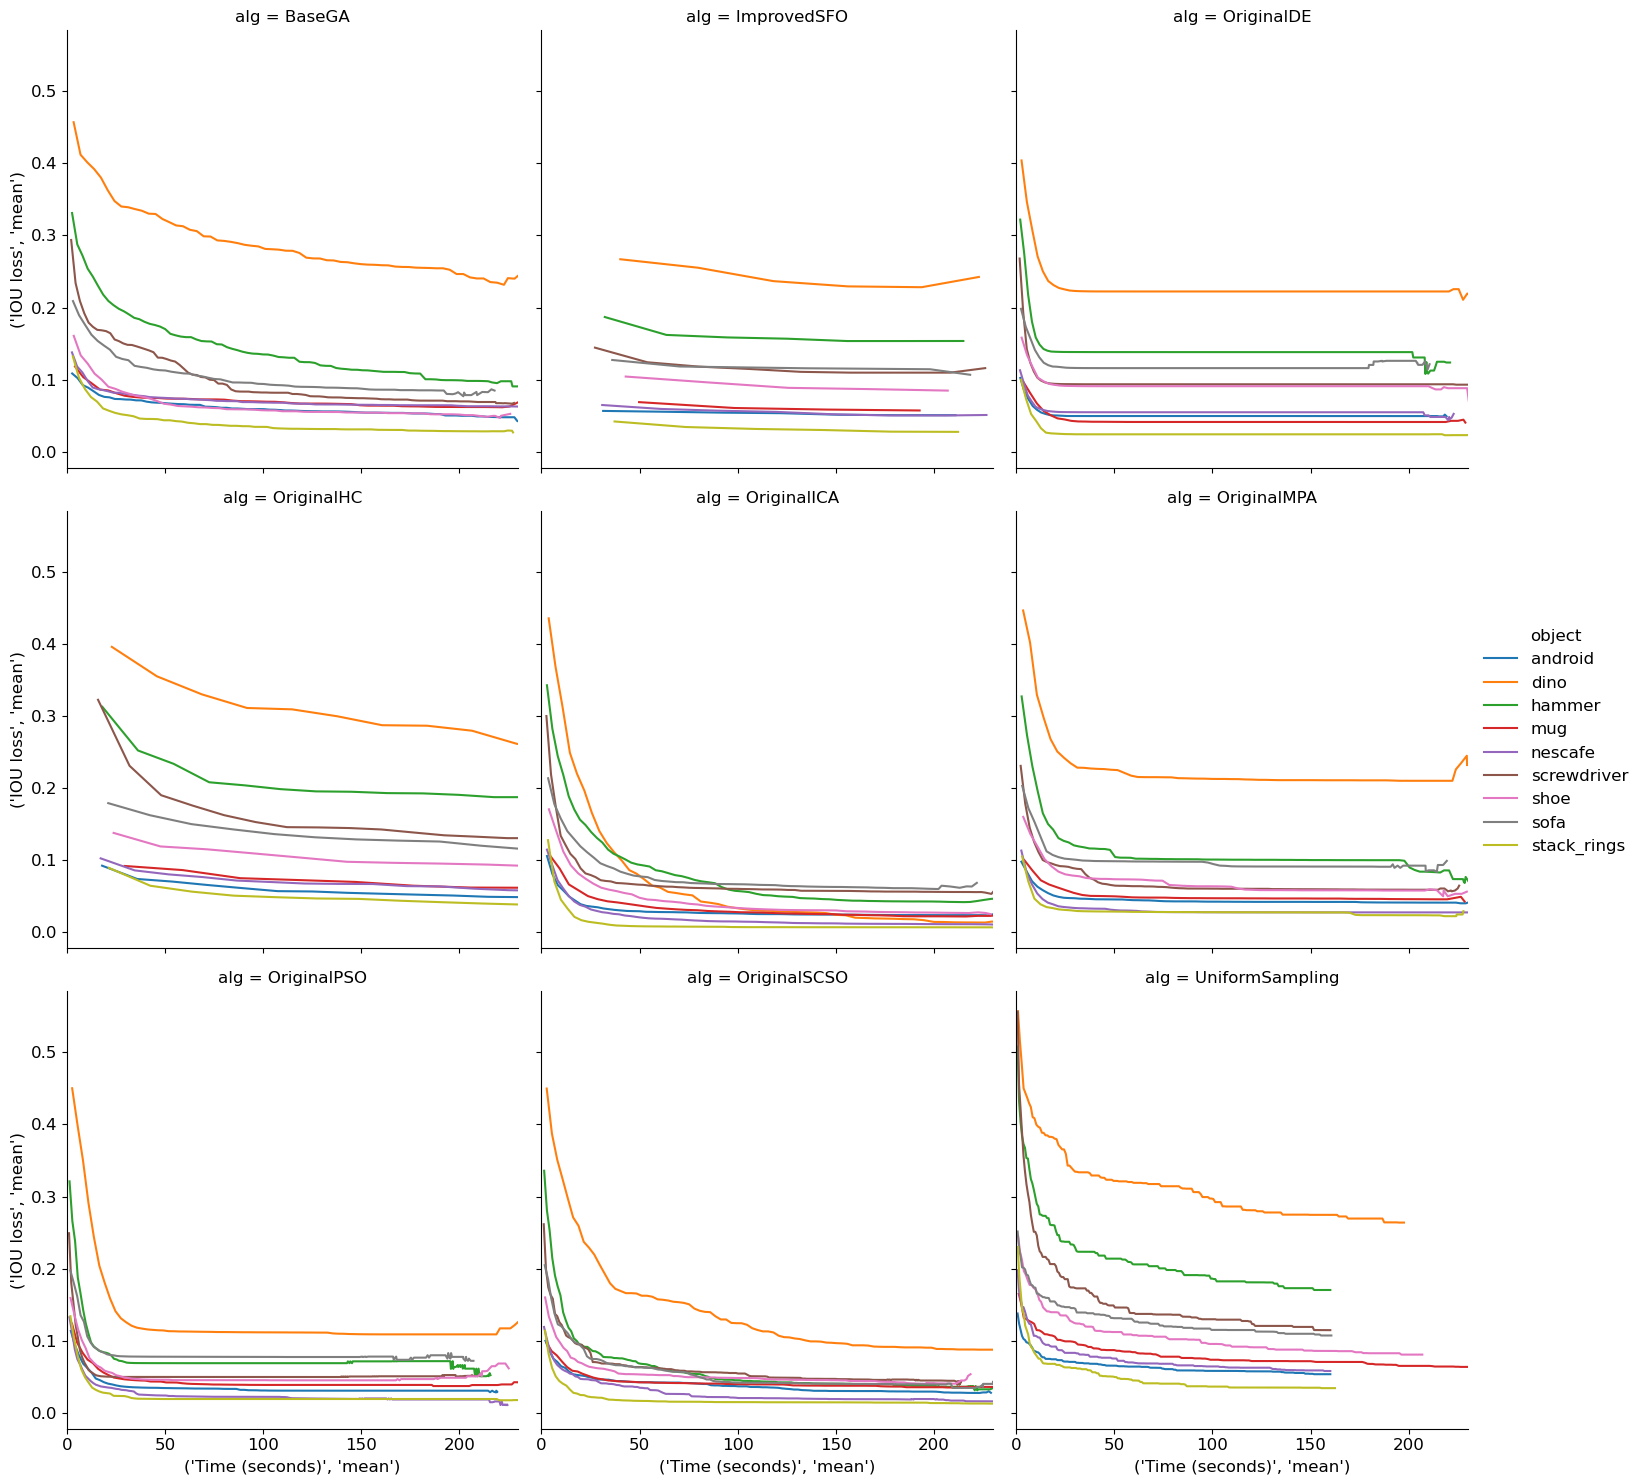

In [18]:
# plot raw data

mask =  (histstats['alg'] == "OriginalICA") # & (histstats['sample'] == 0) (histstats['object'] == 'mug') &
algs = histstats['alg'].unique()


# g = sns.relplot(data=histstats, x='list_epoch_time', y='list_global_best_fit', col='alg', col_wrap=3, kind='line', hue='object', units='sample', estimator=None,  facet_kws={'xlim': (0, 300)})
# g = sns.relplot(data=histmedians, x='list_epoch_time', y='list_global_best_fit', col='alg', col_wrap=3, hue='object', col_order=algs, kind='line', facet_kws={'xlim': (0, 300)})

g = sns.relplot(data=histmedians, x=('Time (seconds)', 'mean'), y=('IOU loss','mean'), hue='object', col_order=algs, col='alg', col_wrap=3, kind='line', facet_kws={'xlim': (0, 230)})

# g = sns.lineplot(data=histmedians.loc["OriginalHC"], x='list_epoch_time', y='list_global_best_fit', hue='object', errorbar='sd', alpha=1)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# g.set_axis_labels(x_var="time (second)", y_var="IOU loss")

# for alg, object, epoch in errors.index:
# for object in config.OBJECT_NAMES:
    # df = errors.loc['OriginalHC', object, :]
# g.plot(df['list_epoch_time']['mean'], df['list_global_best_fit']['mean'], alpha=1)
    # g.fill_between(x=df['list_epoch_time']['mean'], y1=df['list_global_best_fit']['25%'], y2=df['list_global_best_fit']['75%'], alpha=0.15)

# g.figure.set_size_inches(15,10)
# g.set(xscale="log")
g.set(yscale="log")

# g.ax.set_xlim([0,200])
# g.set(xlim=(0, 30))
# for ax in g.axes:
#     ax.autoscale()
#     ax.autoscale_view()
g.figure.tight_layout()
plt.show()

In [ ]:
histAlgMeans = histstats.drop(columns=["object","sample"]).groupby(by=["alg", "epoch"]).mean()

In [ ]:
# plot means

mask =  (histstats['alg'] == "OriginalICA") # & (histstats['sample'] == 0) (histstats['object'] == 'mug') &
algs = histstats['alg'].unique()

# g = sns.relplot(data=histAlgMeans, x='list_epoch_time', y='list_global_best_fit', kind='line', hue='alg', facet_kws={'xlim': (0, 200)}, estimator=None)
g = sns.relplot(data=histAlgMeans, x='list_epoch_time', y='list_global_best_fit', hue='alg', kind='line', facet_kws={'xlim': (0, 200)})
# g = sns.lineplot(data=histmedians.loc["OriginalHC"], x='list_epoch_time', y='list_global_best_fit', hue='object', errorbar='sd', alpha=1)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_axis_labels(x_var='Time (seconds)', y_var='IOU loss')

# for alg, object, epoch in errors.index:
# for object in config.OBJECT_NAMES:
    # df = errors.loc['OriginalHC', object, :]
# g.plot(df['list_epoch_time']['mean'], df['list_global_best_fit']['mean'], alpha=1)
    # g.fill_between(x=df['list_epoch_time']['mean'], y1=df['list_global_best_fit']['25%'], y2=df['list_global_best_fit']['75%'], alpha=0.15)

# g.figure.set_size_inches(15,10)
# g.set(xscale="log")
g.set(yscale="log")

# g.ax.set_xlim([0,200])
# g.set(xlim=(0, 30))
# for ax in g.axes:
#     ax.autoscale()
#     ax.autoscale_view()
g.figure.tight_layout()
plt.show()
g.figure.savefig("Final_Evaluation2/final_algs_LossVsTime.jpg")

In [ ]:
sns.lineplot(data=histstats, x='list_epoch_time', y='list_global_best_fit', hue="alg")

### Statistics per sample

In [ ]:
raw_data = []
stat_data = []
count = {}

for directory in directories:
    files = LogFiles(directory, return_full_path=False)
    count[directory] = len(files)
    for filename in files:
        if "SwarmSA" in filename or "FFA" in filename:
            continue
        df = files.to_dataframe(add_params=False)
        df = df.assign(object=directories.get_filename())
        raw_data.append(df)

        stat_df = files.eval_stats_dataframe(False)
        stat_df = stat_df.assign(object=directories.get_filename())
        stat_data.append(stat_df)
        


dataframe = pd.concat(raw_data, axis=0, ignore_index=True)
statsframe = pd.concat(stat_data, axis=0, ignore_index=True)

In [ ]:
statsframe.columns

In [ ]:
statsframe.sort_values(by=['object','median'], inplace=True)
statsframe.head(10)

In [ ]:
ordering_df = pd.DataFrame(statsframe.groupby(by=["alg"]).describe()['median'])
ordering_df.sort_values(by=['mean'], inplace=True)
# ordering_df = ordering_df.round(3)
# ordering_df.to_latex("latex.lyx", columns=["mean", "std", "50%"], float_format="%.3f")

In [ ]:
ordering_df.head(20)

In [ ]:
statsframe.groupby(by=["alg"]).describe()[["median"]]

### plot

In [17]:
import matplotlib
matplotlib.rcParams.update({'font.size':12})

In [ ]:
# plot tuning
algs = statsframe['alg'].unique().tolist()

for alg in algs:
    # df_mask = dataframe['object'] == object
    # sf_mask = statsframe['object'] == object
    df = dataframe.groupby(by=["alg"]).get_group((alg,))
    # stats = statsframe.groupby(by=["alg","params"]).get_group((alg,)).sort_values(by=['','median'], inplace=True)
    g = sns.catplot(
        data=df,
        x='params',
        y="eval_loss",
        # row="object",
        # hue="alg",
        kind="box",
        errorbar="sd",
        aspect=6,
        legend=False,
        # col_order=statsframe['alg'],
        # order=statsframe[sf_mask]['alg'],
        # hue_order=statsframe['alg'],
        # col_wrap=20,
        sharex=False,
    )

    # g.figure.set_dpi(400)
    for ax in g.axes.tolist():
        ax = ax[0]
        ax.tick_params(axis="x", rotation=90)
        # ax.set_title(f"PSO GridSearch ordered by median eval loss")

        ax.autoscale_view()
        ax.autoscale()
    g.figure.tight_layout()
    g.figure.suptitle(f"{alg}")
    # g.figure.savefig("AllOptimizers/all_algs.jpg")


In [ ]:
objects = statsframe['object'].unique().tolist()

for object in objects:
    df_mask = dataframe['object'] == object
    sf_mask = statsframe['object'] == object

    g = sns.catplot(
        data=dataframe[df_mask],
        x='alg',
        y="eval_loss",
        row="object",
        hue="alg",
        kind="box",
        errorbar="sd",
        aspect=6,
        legend=False,
        # col_order=statsframe['alg'],
        order=statsframe[sf_mask]['alg'],
        # hue_order=statsframe['alg'],
        # col_wrap=20,
        sharex=False,
    )

    # g.figure.set_dpi(400)
    for ax in g.axes.tolist():
        ax = ax[0]
        ax.tick_params(axis="x", rotation=90)
        # ax.set_title(f"PSO GridSearch ordered by median eval loss")

        ax.autoscale_view()
        ax.autoscale()
    g.figure.tight_layout()
    # g.figure.savefig("AllOptimizers/all_algs.jpg")


In [ ]:
# plot raw data

g = sns.catplot(
    data=dataframe,
    x='alg',
    y="eval_loss",
    # row="object",
    hue="object",
    kind="box",
    errorbar="sd",
    aspect=26,
    legend='brief',
    # col_order=statsframe['alg'],
    order=statsframe['alg'],
    # hue_order=statsframe['alg'],
    # col_wrap=20,
    sharex=False,
)

# g.figure.set_dpi(400)
for ax in g.axes.tolist():
    ax = ax[0]
    ax.tick_params(axis="x", rotation=90)
    # ax.set_title(f"PSO GridSearch ordered by median eval loss")

    ax.autoscale_view()
    ax.autoscale()
g.figure.tight_layout()
# g.figure.savefig("AllOptimizers/all_algs.jpg")


In [ ]:
algs = statsframe['alg'].unique().tolist()

df_list = []
for alg in algs:   
    mask = statsframe['alg'] == alg
    means_list = statsframe[mask]['median'].tolist()
    median = np.median(means_list)
    mean = np.mean(means_list)
    std = np.std(means_list)
    min_val = np.min(means_list)
    max_val = np.max(means_list)

    data = {
        "alg": [alg],
        "mean": [mean],
        "median": [median],
        "std": [std],
        "min_val": [min_val],
        "max_val": [max_val],
    }
    df_list.append(pd.DataFrame(data))

statsframe_stats = pd.concat(df_list, axis=0, ignore_index=True)

In [ ]:
statsframe_stats.sort_values(by=['mean'], inplace=True)
statsframe_stats.head(20)

In [ ]:
statsframe_stats.head(10)['alg'].tolist()

In [ ]:
ordering_df.sort_values(by=['50%'], inplace=True)

In [ ]:
ordering_df.head()

In [ ]:
# plot raw data
algs = ordering_df.index[100:]
mask = statsframe['alg'].isin(algs)
g = sns.catplot(
    data=statsframe[mask],
    x='alg',
    y="mean",
    # row="object",
    hue="alg",
    kind="box",
    errorbar="sd",
    aspect=4,
    legend=False,
    # col_order=statsframe['alg'],
    order=ordering_df.index[100:],
    hue_order=ordering_df.index[100:],
    # col_wrap=20,
    sharex=False,
)

# g.figure.set_dpi(400)
for ax in g.axes.tolist():
    ax = ax[0]
    ax.tick_params(axis="x", rotation=90)
    # ax.set_title(f"PSO GridSearch ordered by median eval loss")

    ax.autoscale_view()
    ax.autoscale()

g.figure.suptitle(f"Mean XorDiff loss of al algorithms over all objects; Default parameters")
g.ax.set_xlabel('')
g.ax.set_ylabel('Mean XorDiff')
# g.ax.set_ylim([0,1.7])
g.figure.tight_layout()
g.figure.savefig("AllOptimizers/algs_mean_median_loss_Part2.jpg", dpi=150)



# Detele?

In [ ]:

for idx, file_path in enumerate(statsframe['path'].to_list()):
    root = files.root
    log = MealLog.load(file_path)
    params = log.alg_params
    if params['empire_count'] == 7 and params['revolution_prob'] == 0.4 and params['revolution_rate'] == 0.4:
        print(f"position={idx} - {log.alg_params}")


In [ ]:
from typing import Iterable
import numpy as np
from itertools import product
import cv2 as cv

from view_sampler import *
from algs import *

import loss_funcs
from evaluate import eval_funcs

from evaluate.dataset import Dataset
from evaluate.eval_log import MealLog
from evaluate.evaluator import Evaluator
from evaluate.dataset import Dataset
from utils.visualize import *
from utils.concurrent import TqdmPool, silence_output

from main2 import evaluate

import mealpy


OBJECT_NAMES = ["airplane", "hammer", "mug"]

PARAMS: dict[str, dict[str, list]] = {
    mealpy.swarm_based.PSO.OriginalPSO.__name__: {
        "c1": [1, 2.05, 3],
        "c2": [1, 2.05, 3],
        "w": [0.2, 0.4, 0.8],
    },

    mealpy.human_based.ICA.OriginalICA.__name__: {
        "empire_count": [4, 7, 10],
        "assimilation_coeff": [1.5, 2.5],
        "revolution_prob": np.linspace(0.02, 0.4, 3),
        "revolution_rate": np.linspace(0.05, 0.4, 3),
        "revolution_step_size": np.linspace(0.05, 0.3, 3),
    },
    mealpy.human_based.SARO.OriginalSARO.__name__: {
        "se": [0.3, 0.5, 0.7],
        "mu": [5, 10, 15, 20],
    },

    mealpy.evolutionary_based.DE.OriginalDE.__name__: {"strategy": range(6)},
    mealpy.math_based.PSS.OriginalPSS.__name__: {
        "acceptance_rate": [0.8, 0.9, 0.95],
    },
    mealpy.math_based.HC.OriginalHC.__name__: {"neighbour_size": [50, 200, 700, 950]},
}


OPTIMIZERS = [
    mealpy.swarm_based.PSO.OriginalPSO,
    mealpy.swarm_based.MSA.OriginalMSA,
    mealpy.swarm_based.SCSO.OriginalSCSO,
    mealpy.physics_based.SA.OriginalSA,
    mealpy.physics_based.EVO.OriginalEVO,
    mealpy.physics_based.EFO.DevEFO,
    mealpy.physics_based.EO.ModifiedEO,
    mealpy.human_based.ICA.OriginalICA,
    mealpy.human_based.FBIO.DevFBIO,
    mealpy.human_based.SARO.OriginalSARO,
    mealpy.evolutionary_based.GA.BaseGA,
    mealpy.evolutionary_based.CRO.OCRO,
    mealpy.evolutionary_based.DE.OriginalDE,
    mealpy.math_based.PSS.OriginalPSS,
    mealpy.math_based.SCA.DevSCA,
    mealpy.math_based.HC.OriginalHC,
]


OBJ_LOCATION = (0, 1.3, 0.3)

In [ ]:

exec = TqdmPool(4)

run_config = MealRunConfig(time_limit=15, silent=True, seed=0)

dataset = Dataset.create_random(location=OBJ_LOCATION, num_samples=20, seed=1)

results = []

tasks = []

for optimizer_type in OPTIMIZERS:

    optimizer_params = PARAMS[optimizer_type.__name__]

    for param_config in product(*optimizer_params.values()):
        if len(param_config) == 0:
            continue

        kwargs = {}
        for i, param_name in enumerate(optimizer_params.keys()):
            kwargs[param_name] = param_config[i]

        try:
            optimizer = optimizer_type()
            optimizer.set_parameters(kwargs)

            for obj_name in OBJECT_NAMES:

                task = exec.submit(
                    evaluate,
                    optimizer=optimizer,
                    run_config=run_config,
                    obj_name=obj_name,
                    eval_positions=dataset,
                    log_folder=f"grid_search/{obj_name}",
                )

        except Exception as e:
            print(f"Failed to create optimizer {optimizer_type.__name__} with params {kwargs}")
            print(str(e))

exec.shutdown(wait=True)


In [ ]:
exec.shutdown(wait=True)
